# Data Mining 483 - Project: ENRON DATASET ANALYSIS 

### Load important libraries 

In [1]:
import pandas as pd
import numpy as np
import re
from multiprocessing import Pool
%matplotlib inline

### Read the raw enron 'csv' file 

In [147]:
df = pd.read_csv('data/emails.csv')
df.head()

,file,message
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...


In [3]:
df.shape

(517401, 2)

In [151]:
print(df.message.sample(1000).iloc[20])

Message-ID: <4771887.1075852307598.JavaMail.evans@thyme>
Date: Mon, 29 Oct 2001 23:10:21 -0800 (PST)
From: customerservice@industrialinfo.com
To: esaibi@enron.com, mailer@industrialinfo.com
Subject: Daily Outage Updates (excluding WSCC)
Mime-Version: 1.0
Content-Type: text/plain; charset=us-ascii
Content-Transfer-Encoding: 7bit
X-From: customerservice@industrialinfo.com@ENRON
X-To: esaibi@enron.com, mailer@industrialinfo.com
X-cc: 
X-bcc: 
X-Folder: \ESAIBI (Non-Privileged)\Saibi, Eric\Inbox
X-Origin: SAIBI-E
X-FileName: ESAIBI (Non-Privileged).pst

Hello Eric Saibi,

 This is an automated email delivery.  The following info is for
 tracking purposes only:

 Transaction: 0000183670
 Fulfillment: 00202135*00002
 Location   : 00004

 Industrial Information Resources, Inc.
 Customer Service Department
 (713) 783-5147


 - OUTAGE.dbf 


In [3]:
#load samples into docs, to find most frequent keys, and load them in an array
docs = df.message.sample(1000)
allkeys = [re.findall('\n([\w\-]+):', doc[:doc.find('\n\n')]) for doc in docs]
allkeys = sum(allkeys,[])
allkeys = set(allkeys)

#added the predefined keys to the array
allkeys.add('Message-ID')
allkeys.add('Body')

### Generated the following list of keys, present in all of the messages 

In [14]:
allkeys 

{'Bcc',
 'Body',
 'Cc',
 'Content-Transfer-Encoding',
 'Content-Type',
 'Date',
 'From',
 'Message-ID',
 'Mime-Version',
 'Subject',
 'To',
 'X-FileName',
 'X-Folder',
 'X-From',
 'X-Origin',
 'X-To',
 'X-bcc',
 'X-cc'}

### Parse function 

In [4]:
#This function will tokenize/ seggregate message content into 'key-value' pair needed. The keys are taken from 'allkeys'

def parse(doc):
    keys = ['Message-ID']+re.findall('\n([\w\-]+):', doc[:doc.find('\n\n')])
    keys = pd.Series(keys).drop_duplicates().tolist()

    values = []
    for a, k in enumerate(keys):
        k = k+':'
        try:
            values.append(doc[doc.find(k)+len(k):doc.find(keys[a+1])].strip())
        except:
            values.append(doc[doc.find(k)+len(k):doc.find('\n\n')].strip())
    
    d = dict(zip(keys+['Body'],values+[doc[doc.find('\n\n'):].strip()]))
    k_to_remove = set(d.keys()) - set(allkeys)
    k_to_add = set(allkeys) - set(d.keys())
    
    for k in k_to_remove:
        d.pop(k)
    for k in k_to_add:
        d[k] = ''

    keys = [k[:-1] for k in keys]
    return d

In [16]:
#Sample: Parsing the '0' th value 
parse(df.message.sample().iloc[1])

{'Message-ID': '<13665651.1075844464309.JavaMail.evans@thyme>',
 'Date': 'Thu, 7 Dec 2000 08:10:00 -0800 (PST)',
 'From': 'exchangeinfo@nymex.com',
 'To': 'sara.shackleton@enron.com',
 'Subject': '(00-419) CFTC Approves Amendments to Natural Gas Price Limit Rules',
 'Mime-Version': '1.0',
 'Content-Type': 'text/plain; charset=ANSI_X3.4-1968',
 'Content-Transfer-Encoding': 'quoted-printable',
 'X-From': 'exchangeinfo@nymex.com',
 'X-To': 'sara.shackleton@enron.com',
 'X-cc': '',
 'X-bcc': '',
 'X-Folder': '\\Sara_Shackleton_Dec2000_June2001_1\\Notes Folders\\Notes inbox',
 'X-Origin': 'SHACKLETON-S',
 'X-FileName': 'sshackle.nsf',
 'Body': 'TO: All New York Mercantile Exchange Members\n\nFROM: Neal Wolkoff, Executive Vice President\n\nRE: CFTC Approves Amendments to Natural Gas Price Limit Rules\n\nDATE: December 7, 2000\n\nNotice # 00-419\n\n______________________________________________\n\nThe New York Mercantile Exchange, Inc., has received permission from the=20\nCommodity Futures T

### Using multiprocessing libray to parse documents in parallel using 7 cpu processes  

In [5]:
p = Pool(7)
dics = p.map(parse, df.message)
p.close()

In [17]:
from collections import defaultdict
from datetime import datetime 

dd = defaultdict(list)

for d in dics:
    for key, value in d.items():
        dd[key].append(value)
        
df_parsed = pd.DataFrame(dd)
df_parsed['file'] = df.file
df_parsed['Date_'] = pd.to_datetime(df_parsed.Date, infer_datetime_format=True)
#backup data into pickle file 
df_parsed.to_pickle('df_parsed.pkl')

### Transformed data 

In [18]:
df_parsed.head()

,Message-ID,Date,From,To,Subject,Mime-Version,Content-Type,Content-Transfer-Encoding,X-From,X-To,X-cc,X-bcc,X-Folder,X-Origin,X-FileName,Body,Cc,Bcc,file,Date_
0,<18782981.1075855378110.JavaMail.evans@thyme>,"Mon, 14 May 2001 16:39:00 -0700 (PDT)",phillip.allen@enron.com,tim.belden@enron.com,,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Tim Belden <Tim Belden/Enron@EnronXGate>,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Here is our forecast,,,allen-p/_sent_mail/1.,2001-05-14 23:39:00
1,<15464986.1075855378456.JavaMail.evans@thyme>,"Fri, 4 May 2001 13:51:00 -0700 (PDT)",phillip.allen@enron.com,john.lavorato@enron.com,Re:,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,John J Lavorato <John J Lavorato/ENRON@enronXg...,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Traveling to have a business meeting takes the...,,,allen-p/_sent_mail/10.,2001-05-04 20:51:00
2,<24216240.1075855687451.JavaMail.evans@thyme>,"Wed, 18 Oct 2000 03:00:00 -0700 (PDT)",phillip.allen@enron.com,leah.arsdall@enron.com,Re: test,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Leah Van Arsdall,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,test successful. way to go!!!,,,allen-p/_sent_mail/100.,2000-10-18 10:00:00
3,<13505866.1075863688222.JavaMail.evans@thyme>,"Mon, 23 Oct 2000 06:13:00 -0700 (PDT)",phillip.allen@enron.com,randall.gay@enron.com,,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Randall L Gay,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,"Randy,\n\n Can you send me a schedule of the s...",,,allen-p/_sent_mail/1000.,2000-10-23 13:13:00
4,<30922949.1075863688243.JavaMail.evans@thyme>,"Thu, 31 Aug 2000 05:07:00 -0700 (PDT)",phillip.allen@enron.com,greg.piper@enron.com,Re: Hello,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Greg Piper,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,Let's shoot for Tuesday at 11:45.,,,allen-p/_sent_mail/1001.,2000-08-31 12:07:00


In [9]:
df_parsed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517401 entries, 0 to 517400
Data columns (total 20 columns):
Message-ID                   517401 non-null object
Date                         517401 non-null object
From                         517401 non-null object
To                           517401 non-null object
Subject                      517401 non-null object
Mime-Version                 517401 non-null object
Content-Type                 517401 non-null object
Content-Transfer-Encoding    517401 non-null object
X-From                       517401 non-null object
X-To                         517401 non-null object
X-cc                         517401 non-null object
X-bcc                        517401 non-null object
X-Folder                     517401 non-null object
X-Origin                     517401 non-null object
X-FileName                   517401 non-null object
Body                         517401 non-null object
Cc                           517401 non-null object
Bcc  

In [159]:
#df_parsed
df_parsed.loc[df_parsed['From'] == 'tim.belden@enron.com']

,Message-ID,Date,From,To,Subject,Mime-Version,Content-Type,Content-Transfer-Encoding,X-From,X-To,...,X-bcc,X-Folder,X-Origin,X-FileName,Body,Cc,Bcc,file,bodyWordCount,subjectWordCount
Date_,,,,,,,,,,,,,,,,,,,,,
2000-12-05 06:42:00,<32727179.1075855666592.JavaMail.evans@thyme>,"Mon, 4 Dec 2000 22:42:00 -0800 (PST)",tim.belden@enron.com,phillip.allen@enron.com,"New Generation, Nov 30th",1.0,text/plain; charset=us-ascii,7bit,Tim Belden,Phillip K Allen,...,,\Phillip_Allen_Dec2000\Notes Folders\All docum...,Allen-P,pallen.nsf,---------------------- Forwarded by Tim Belden...,,,allen-p/all_documents/50.,132,4
2000-12-05 06:42:00,<22187423.1075855677436.JavaMail.evans@thyme>,"Mon, 4 Dec 2000 22:42:00 -0800 (PST)",tim.belden@enron.com,phillip.allen@enron.com,"New Generation, Nov 30th",1.0,text/plain; charset=us-ascii,7bit,Tim Belden,Phillip K Allen,...,,\Phillip_Allen_Dec2000\Notes Folders\Discussio...,Allen-P,pallen.nsf,---------------------- Forwarded by Tim Belden...,,,allen-p/discussion_threads/190.,132,4
2000-12-05 06:42:00,<23201664.1075855679700.JavaMail.evans@thyme>,"Mon, 4 Dec 2000 22:42:00 -0800 (PST)",tim.belden@enron.com,phillip.allen@enron.com,"New Generation, Nov 30th",1.0,text/plain; charset=us-ascii,7bit,Tim Belden,Phillip K Allen,...,,\Phillip_Allen_Dec2000\Notes Folders\Notes inbox,Allen-P,pallen.nsf,---------------------- Forwarded by Tim Belden...,,,allen-p/notes_inbox/40.,132,4
2000-08-20 21:12:00,<14117042.1075863589355.JavaMail.evans@thyme>,"Sun, 20 Aug 2000 14:12:00 -0700 (PDT)",tim.belden@enron.com,"robert.badeer@enron.com, jeff.richter@enron.com",RE: Path 26 OTC increase -- IMPORTANT,1.0,text/plain; charset=us-ascii,7bit,Tim Belden,"Robert Badeer, Jeff Richter",...,,\Robert_Badeer_Aug2000\Notes Folders\All docum...,Badeer-R,rbadeer.nsf,check this out and let everyone know what's up...,,,badeer-r/all_documents/101.,328,6
2000-08-15 06:23:00,<29455071.1075863590001.JavaMail.evans@thyme>,"Mon, 14 Aug 2000 23:23:00 -0700 (PDT)",tim.belden@enron.com,"robert.badeer@enron.com, christian.yoder@enron...",PX Letter,1.0,text/plain; charset=us-ascii,7bit,Tim Belden,"Robert Badeer, Christian Yoder",...,,\Robert_Badeer_Aug2000\Notes Folders\All docum...,Badeer-R,rbadeer.nsf,"Please see the attached. Christian, could you...",,,badeer-r/all_documents/129.,78,2
2000-08-08 09:51:00,<6786378.1075863590703.JavaMail.evans@thyme>,"Tue, 8 Aug 2000 02:51:00 -0700 (PDT)",tim.belden@enron.com,robert.badeer@enron.com,CAISO Congestion Model,1.0,text/plain; charset=us-ascii,7bit,Tim Belden,Robert Badeer,...,,\Robert_Badeer_Aug2000\Notes Folders\All docum...,Badeer-R,rbadeer.nsf,put this into the congestion redesign file if ...,,,badeer-r/all_documents/155.,473,3
2000-08-01 06:32:00,<5678104.1075863591087.JavaMail.evans@thyme>,"Mon, 31 Jul 2000 23:32:00 -0700 (PDT)",tim.belden@enron.com,jeff.dasovich@enron.com,information from iso,1.0,text/plain; charset=us-ascii,7bit,Tim Belden,Jeff Dasovich,...,,\Robert_Badeer_Aug2000\Notes Folders\All docum...,Badeer-R,rbadeer.nsf,i would categorize things in the following man...,"robert.badeer@enron.com, jeff.richter@enron.com","robert.badeer@enron.com, jeff.richter@enron.com",badeer-r/all_documents/171.,310,3
2000-08-28 15:15:00,<21078838.1075863587631.JavaMail.evans@thyme>,"Mon, 28 Aug 2000 08:15:00 -0700 (PDT)",tim.belden@enron.com,"chris.foster@enron.com, murray.o'neil@enron.co...",Out of Office,1.0,text/plain; charset=us-ascii,7bit,Tim Belden,"Chris H Foster, Murray P O'Neil, John M Forney...",...,,\Robert_Badeer_Aug2000\Notes Folders\All docum...,Badeer-R,rbadeer.nsf,I will be traveling to Calgary on Tuesday and ...,,,badeer-r/all_documents/28.,35,3
2000-08-28 09:50:00,<27742023.1075863587827.JavaMail.evans@thyme>,"Mon, 28 Aug 2000 02:50:00 -0700 (PDT)",tim.belden@enron.com,"mike.swerzbin@enron.com, robert.badeer@enron.c...",Out of Office Procedure,1.0,text/plain; charset=us-ascii,7bit,Tim Belden,"Mike Swerzbin, Robert Badeer, Sean Crandall, T...",...,,\Robert_Badeer_Aug2000\Notes Folders\All do

In [10]:
df_parsed.dtypes

Message-ID                           object
Date                                 object
From                                 object
To                                   object
Subject                              object
Mime-Version                         object
Content-Type                         object
Content-Transfer-Encoding            object
X-From                               object
X-To                                 object
X-cc                                 object
X-bcc                                object
X-Folder                             object
X-Origin                             object
X-FileName                           object
Body                                 object
Cc                                   object
Bcc                                  object
file                                 object
Date_                        datetime64[ns]
dtype: object

In [19]:
df_parsed.set_index('Date_',inplace=True)

In [20]:
(lambda x: set(x[:146].index))(df_parsed['From'].value_counts())

{'40enron@enron.com',
 'alan.comnes@enron.com',
 'ami.chokshi@enron.com',
 'andrea.ring@enron.com',
 'andy.zipper@enron.com',
 'ann.schmidt@enron.com',
 'announcements.enron@enron.com',
 'arsystem@mailman.enron.com',
 'barry.tycholiz@enron.com',
 'ben.jacoby@enron.com',
 'benjamin.rogers@enron.com',
 'bill.iii@enron.com',
 'bill.williams@enron.com',
 'cara.semperger@enron.com',
 'carol.clair@enron.com',
 'cheryl.nelson@enron.com',
 'chris.dorland@enron.com',
 'chris.germany@enron.com',
 'chris.stokley@enron.com',
 'christi.nicolay@enron.com',
 'd..steffes@enron.com',
 'dan.hyvl@enron.com',
 'dana.davis@enron.com',
 'daren.farmer@enron.com',
 'darrell.schoolcraft@enron.com',
 'darron.giron@enron.com',
 'david.delainey@enron.com',
 'david.forster@enron.com',
 'debra.perlingiere@enron.com',
 'drew.fossum@enron.com',
 'dutch.quigley@enron.com',
 'elizabeth.sager@enron.com',
 'enron.announcements@enron.com',
 'enron_update@concureworkplace.com',
 'eric.bass@enron.com',
 'errol.mclaughlin@en

In [44]:
X = df_parsed.drop(['file', 'Mime-Version', 'Content-Type', 'Content-Transfer-Encoding' ], axis=1)
X.head()

,Message-ID,Date,From,To,Subject,X-From,X-To,X-cc,X-bcc,X-Folder,X-Origin,X-FileName,Body,Cc,Bcc
Date_,,,,,,,,,,,,,,,
2001-05-14 23:39:00,<18782981.1075855378110.JavaMail.evans@thyme>,"Mon, 14 May 2001 16:39:00 -0700 (PDT)",phillip.allen@enron.com,tim.belden@enron.com,,Phillip K Allen,Tim Belden <Tim Belden/Enron@EnronXGate>,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Here is our forecast,,
2001-05-04 20:51:00,<15464986.1075855378456.JavaMail.evans@thyme>,"Fri, 4 May 2001 13:51:00 -0700 (PDT)",phillip.allen@enron.com,john.lavorato@enron.com,Re:,Phillip K Allen,John J Lavorato <John J Lavorato/ENRON@enronXg...,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Traveling to have a business meeting takes the...,,
2000-10-18 10:00:00,<24216240.1075855687451.JavaMail.evans@thyme>,"Wed, 18 Oct 2000 03:00:00 -0700 (PDT)",phillip.allen@enron.com,leah.arsdall@enron.com,Re: test,Phillip K Allen,Leah Van Arsdall,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,test successful. way to go!!!,,
2000-10-23 13:13:00,<13505866.1075863688222.JavaMail.evans@thyme>,"Mon, 23 Oct 2000 06:13:00 -0700 (PDT)",phillip.allen@enron.com,randall.gay@enron.com,,Phillip K Allen,Randall L Gay,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,"Randy,\n\n Can you send me a schedule of the s...",,
2000-08-31 12:07:00,<30922949.1075863688243.JavaMail.evans@thyme>,"Thu, 31 Aug 2000 05:07:00 -0700 (PDT)",phillip.allen@enron.com,greg.piper@enron.com,Re: Hello,Phillip K Allen,Greg Piper,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,Let's shoot for Tuesday at 11:45.,,


In [47]:
import re
from nltk.tokenize.regexp import RegexpTokenizer

#tokeniser=RegexpTokenizer(pattern)
tokenizer = RegexpTokenizer(r'(?u)\b\w\w+\b')

In [50]:
df_parsed['subjectWordCount'] = df_parsed['Subject'].map(lambda x: len(tokenizer.tokenize(x)))
df_parsed['bodyWordCount'] = df_parsed['Body'].map(lambda x: len(tokenizer.tokenize(x)))

In [188]:
#users = X-origin 
grouped_by_people = df_parsed.groupby('X-Origin').agg({
        'Body': 'count', 
        'subjectWordCount': 'mean',
        'bodyWordCount': 'mean',
        'From':'count'
    })

In [189]:
grouped_by_people.rename(columns={'Body': '#Emails', 
                                  'subjectWordCount': 'subjectWordCount', 
                                  'bodyWordCount': 'bodyWordCount'}, inplace=True)
grouped_by_people.sort_values('#Emails', ascending=False).head()

,#Emails,subjectWordCount,bodyWordCount,From
X-Origin,,,,
Kaminski-V,26995,4.175884,250.770031,26995
DASOVICH-J,26323,5.227634,601.522129,26323
KEAN-S,23621,4.962703,487.545362,23621
MANN-K,22414,4.211073,207.173463,22414
JONES-T,18598,4.708893,182.767986,18598


In [182]:
Etable = grouped_by_people
Etable = Etable[114:260]

In [183]:
print(Etable.sort_values(by = ['#Emails'], ascending = [False]))
#print(y)

                                              #Emails  subjectWordCount  \
From                                                                      
40enron@enron.com                                2435          5.034497   
2000greetings@postalmanager.com                     9          4.555556   
2740741@skytel.com                                  6          0.000000   
40ees@enron.com                                     6          3.500000   
1800flowers@shop2u.com                              6          9.000000   
1800flowers@1800flowers.flonetwork.com              5          8.000000   
3dnewsletter@news.3dstockcharts.com                 3          5.666667   
1to1web@am.sony.com                                 3          4.000000   
26101652@yahoo.com                                  3          5.000000   
1800flowers.93690065@s2u2.com                       3          7.000000   
40ect@enron.com                                     3          3.000000   
1800flowers.86665396@s2u2

In [178]:
Etable = Etable.reset_index()
Etable.loc[Etable['X-Origin'] == 'Allen-P']

,level_0,index,X-Origin,#Emails,subjectWordCount,bodyWordCount
109,109,109,Allen-P,3034,3.383652,178.506262


In [179]:
Etable.loc[Etable['X-Origin'] == 'Belden-T']Kevin M. Presto

,level_0,index,X-Origin,#Emails,subjectWordCount,bodyWordCount


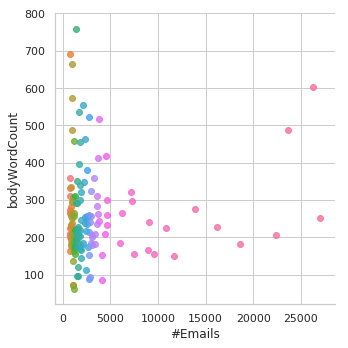

In [87]:
sns.lmplot(x="#Emails", y="bodyWordCount", data=Etable.reset_index(),  hue='X-Origin', fit_reg=False, legend=False)

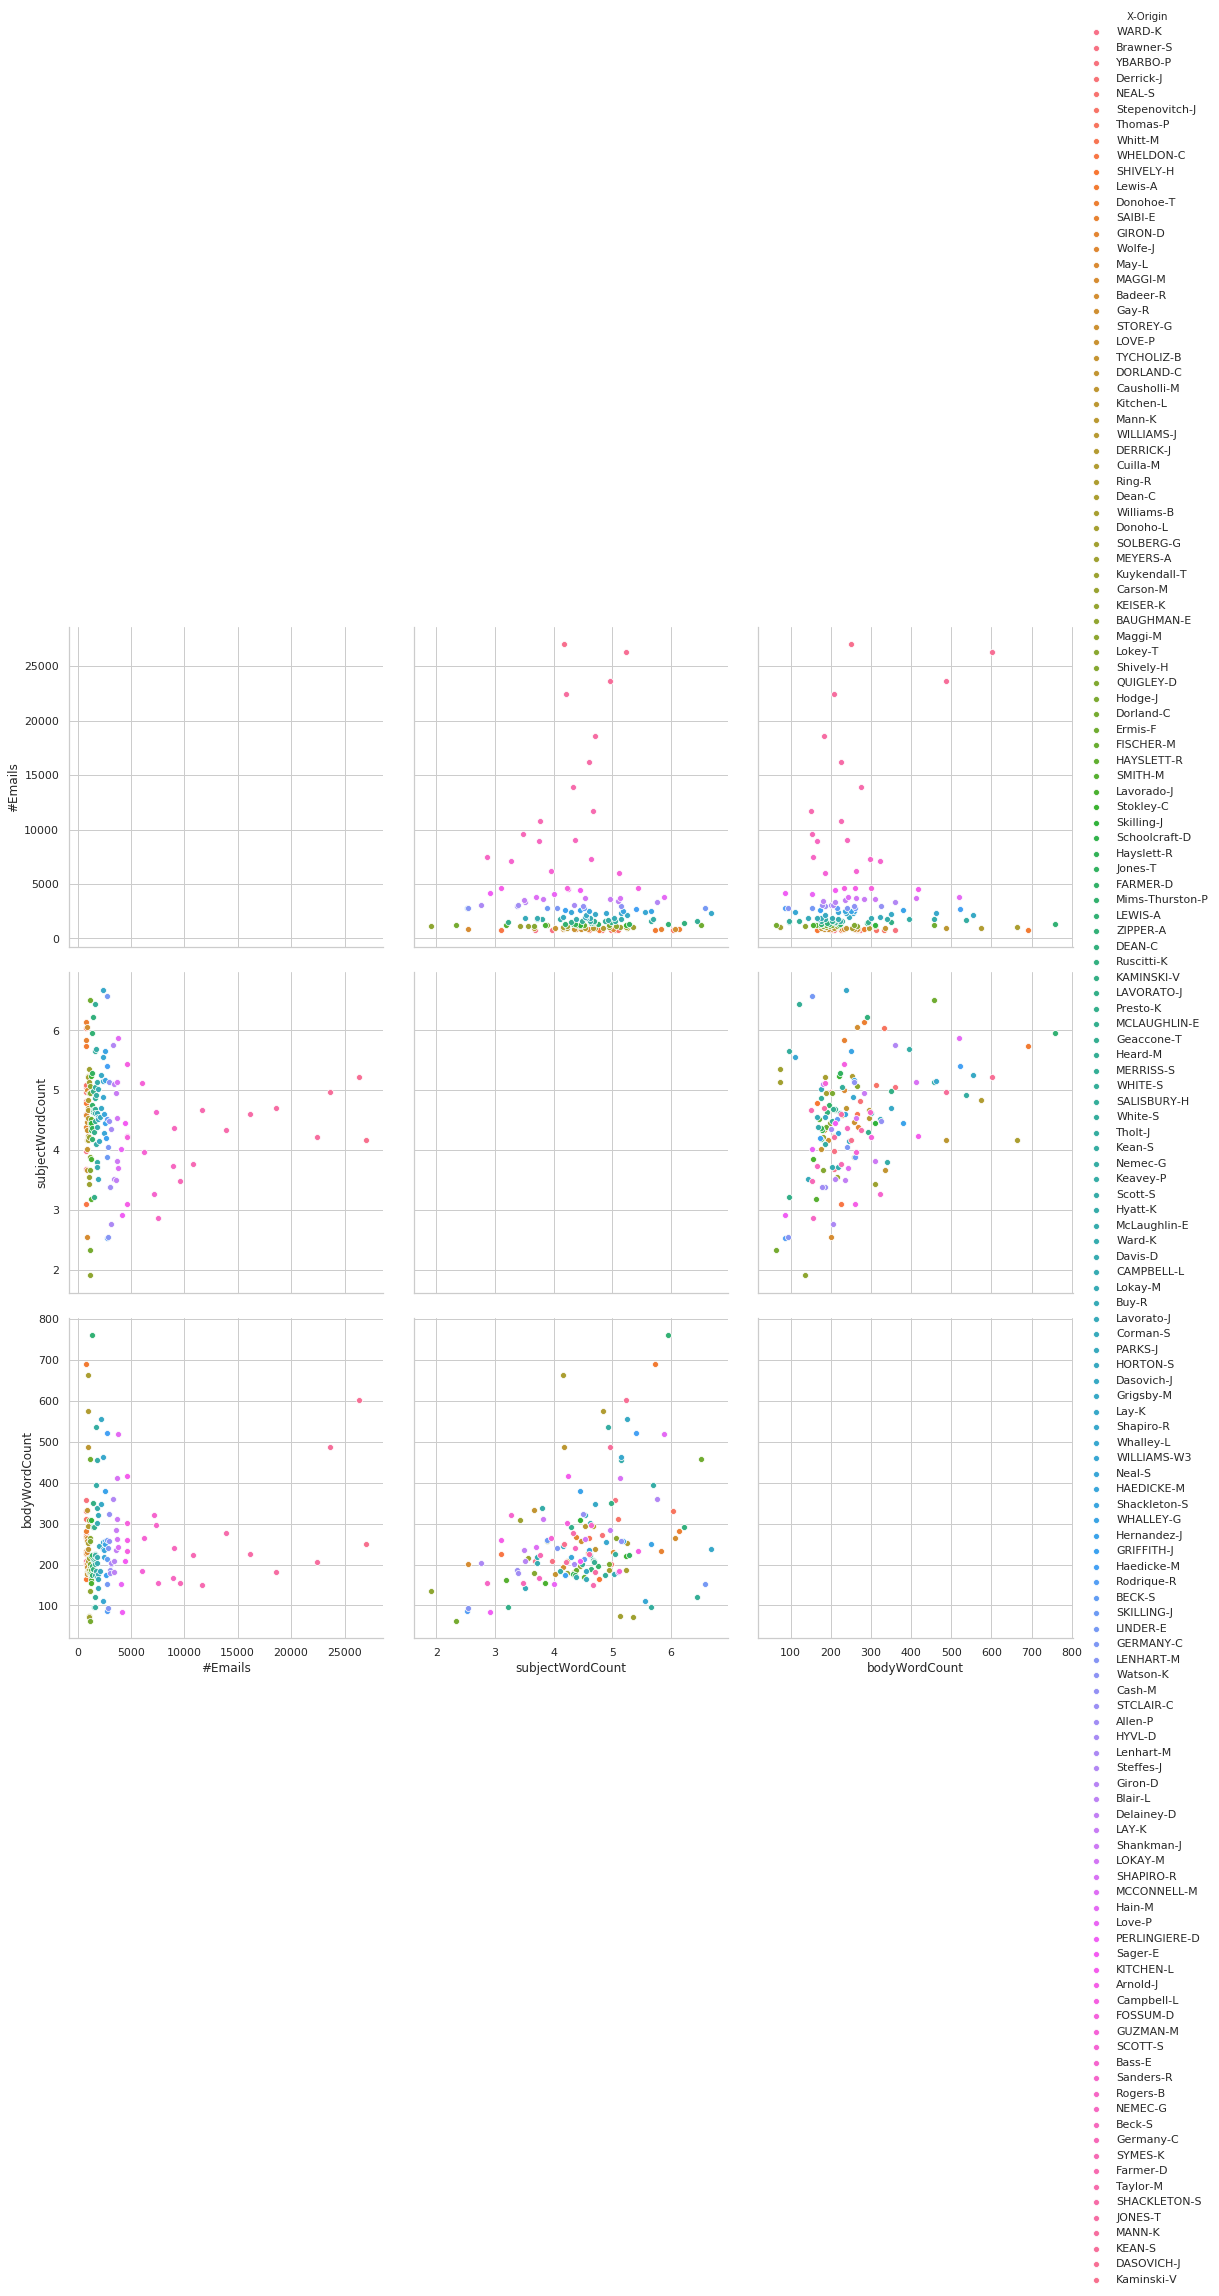

In [79]:
sns.pairplot(Etable.reset_index(), hue='X-Origin', height=5)

### Loading Finacial+Email Data 

In [165]:
import json
import sys
import numpy as np
import pandas as pd
from sklearn.preprocessing import Imputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest,f_classif
import pickle
sys.path.append("../tools/")


with open('resources/ch06-mailboxes/data/enronData.json') as f:
    data = json.load(f)
features_list = ['poi',
                'salary',
                'bonus', 
                'long_term_incentive', 
                'deferred_income', 
                'deferral_payments',
                'loan_advances', 
                'other',
                'expenses', 
                'director_fees',
                'total_payments',
                'exercised_stock_options',
                'restricted_stock',
                'restricted_stock_deferred',
                'total_stock_value',
                'to_messages',
                'from_messages',
                'from_this_person_to_poi',
                'from_poi_to_this_person']


df = pd.DataFrame.from_dict(data)
df.head()

,METTS MARK,BAXTER JOHN C,ELLIOTT STEVEN,CORDES WILLIAM R,HANNON KEVIN P,MORDAUNT KRISTINA M,MEYER ROCKFORD G,MCMAHON JEFFREY,HORTON STANLEY C,PIPER GREGORY F,...,SAVAGE FRANK,IZZO LAWRENCE L,TILNEY ELIZABETH A,MARTIN AMANDA K,BUY RICHARD B,GRAMM WENDY L,CAUSEY RICHARD A,TAYLOR MITCHELL S,DONAHUE JR JEFFREY M,GLISAN JR BEN F
bonus,600000,1200000,350000,NaN,1500000,325000,NaN,2600000,NaN,400000,...,NaN,NaN,300000,NaN,900000,NaN,1000000,600000,800000,600000
deferral_payments,NaN,1295738,NaN,NaN,NaN,NaN,1848227,NaN,3131860,1130036,...,NaN,NaN,NaN,85430,649584,NaN,NaN,227449,NaN,NaN
deferred_income,NaN,-1386055,-400729,NaN,-3117011,NaN,NaN,NaN,NaN,-33333,...,-121284,NaN,-575000,NaN,-694862,NaN,-235000,NaN,-300000,NaN
director_fees,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,125034,NaN,NaN,NaN,NaN,119292,NaN,NaN,NaN,NaN
email_address,mark.metts@enron.com,NaN,steven.elliott@enron.com,bill.cordes@enron.com,kevin.hannon@enron.com,kristina.mordaunt@enron.com,rockford.meyer@enron.com,jeffrey.mcmahon@enron.com,stanley.horton@enron.com,greg.piper@enron.com,...,NaN,larry.izzo@enron.com,elizabeth.tilney@enron.com,a..martin@enron.com,rick.buy@enron.com,NaN,richard.causey@enron.com,mitchell.taylor@enron.com,jeff.donahue@enron.com,ben.glisan@enron.com


In [170]:
df.shape

(21, 146)

In [171]:
dfT = df.T
#dfT = dfT[features_list]
dfT = dfT.replace('NaN', np.nan)
dfT.info()

<class 'pandas.core.frame.DataFrame'>
Index: 146 entries, METTS MARK to GLISAN JR BEN F
Data columns (total 21 columns):
bonus                        82 non-null float64
deferral_payments            39 non-null float64
deferred_income              49 non-null float64
director_fees                17 non-null float64
email_address                111 non-null object
exercised_stock_options      102 non-null float64
expenses                     95 non-null float64
from_messages                86 non-null float64
from_poi_to_this_person      86 non-null float64
from_this_person_to_poi      86 non-null float64
loan_advances                4 non-null float64
long_term_incentive          66 non-null float64
other                        93 non-null float64
poi                          146 non-null bool
restricted_stock             110 non-null float64
restricted_stock_deferred    18 non-null float64
salary                       95 non-null float64
shared_receipt_with_poi      86 non-null float6

In [91]:
dfT.head()

,poi,salary,bonus,long_term_incentive,deferred_income,deferral_payments,loan_advances,other,expenses,director_fees,total_payments,exercised_stock_options,restricted_stock,restricted_stock_deferred,total_stock_value,to_messages,from_messages,from_this_person_to_poi,from_poi_to_this_person
METTS MARK,False,365788.0,600000.0,NaN,NaN,NaN,NaN,1740.0,94299.0,NaN,1061827.0,NaN,585062.0,NaN,585062.0,807.0,29.0,1.0,38.0
BAXTER JOHN C,False,267102.0,1200000.0,1586055.0,-1386055.0,1295738.0,NaN,2660303.0,11200.0,NaN,5634343.0,6680544.0,3942714.0,NaN,10623258.0,NaN,NaN,NaN,NaN
ELLIOTT STEVEN,False,170941.0,350000.0,NaN,-400729.0,NaN,NaN,12961.0,78552.0,NaN,211725.0,4890344.0,1788391.0,NaN,6678735.0,NaN,NaN,NaN,NaN
CORDES WILLIAM R,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,651850.0,386335.0,NaN,1038185.0,764.0,12.0,0.0,10.0
HANNON KEVIN P,True,243293.0,1500000.0,1617011.0,-3117011.0,NaN,NaN,11350.0,34039.0,NaN,288682.0,5538001.0,853064.0,NaN,6391065.0,1045.0,32.0,21.0,32.0


In [172]:
dfT.loc[dfT['email_address'] == 'tim.belden@enron.com']

,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,...,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
BELDEN TIMOTHY N,5249999.0,2144013.0,-2334434.0,NaN,tim.belden@enron.com,953136.0,17355.0,484.0,228.0,108.0,...,NaN,210698.0,True,157569.0,NaN,213999.0,5521.0,7991.0,5501630.0,1110705.0


In [190]:
dfT.loc[dfT['email_address'] == 'phillip.allen@enron.com']

,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,...,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
ALLEN PHILLIP K,4175000.0,2869717.0,-3081055.0,NaN,phillip.allen@enron.com,1729541.0,13868.0,2195.0,47.0,65.0,...,304805.0,152.0,False,126027.0,-126027.0,201955.0,1407.0,2902.0,4484442.0,1729541.0


### Identify the True positive and True negative 

In [92]:
#split of POI and non-POI in the dataset
poi_non_poi = dfT.poi.value_counts()
poi_non_poi.index=['non-POI', 'POI']
print ("POI / non-POI split")
poi_non_poi

POI / non-POI split


non-POI    128
POI         18
Name: poi, dtype: int64

In [94]:
print (" Count of NaN values in the dataset: ", dfT.isnull().sum().sum())
dfT.iloc[:,:15] = dfT.iloc[:,:15].fillna(0)

 Count of NaN values in the dataset:  1263


In [95]:
email_features = ['to_messages', 'from_messages', 'from_this_person_to_poi', 'from_poi_to_this_person']

imp = Imputer(missing_values='NaN', strategy='median', axis=0)

#Replace/impute missing values of email features by median 
dfT.loc[dfT[dfT.poi == 1].index,email_features] = imp.fit_transform(dfT[email_features][dfT.poi == 1])
dfT.loc[dfT[dfT.poi == 0].index,email_features] = imp.fit_transform(dfT[email_features][dfT.poi == 0])

/home/resham/anaconda3/envs/project/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


### Verify the sum of payment columns is equivalent to total payments 

In [96]:
payments = ['salary',
            'bonus', 
            'long_term_incentive', 
            'deferred_income', 
            'deferral_payments',
            'loan_advances', 
            'other',
            'expenses', 
            'director_fees']
dfT[dfT[payments].sum(axis='columns') != dfT.total_payments]

,poi,salary,bonus,long_term_incentive,deferred_income,deferral_payments,loan_advances,other,expenses,director_fees,total_payments,exercised_stock_options,restricted_stock,restricted_stock_deferred,total_stock_value,to_messages,from_messages,from_this_person_to_poi,from_poi_to_this_person
BELFER ROBERT,False,0.0,0.0,0.0,0.0,-102500.0,0.0,0.0,0.0,3285.0,102500.0,3285.0,0.0,44093.0,-44093.0,944.0,41.0,6.0,26.5
BHATNAGAR SANJAY,False,0.0,0.0,0.0,0.0,0.0,0.0,137864.0,0.0,137864.0,15456290.0,2604490.0,-2604490.0,15456290.0,0.0,523.0,29.0,1.0,0.0


### Verify the sum of stock columns is equivalent to total payments 

In [97]:
stock_value = ['exercised_stock_options',
                'restricted_stock',
                'restricted_stock_deferred']
dfT[dfT[stock_value].sum(axis='columns') != dfT.total_stock_value]

,poi,salary,bonus,long_term_incentive,deferred_income,deferral_payments,loan_advances,other,expenses,director_fees,total_payments,exercised_stock_options,restricted_stock,restricted_stock_deferred,total_stock_value,to_messages,from_messages,from_this_person_to_poi,from_poi_to_this_person
BELFER ROBERT,False,0.0,0.0,0.0,0.0,-102500.0,0.0,0.0,0.0,3285.0,102500.0,3285.0,0.0,44093.0,-44093.0,944.0,41.0,6.0,26.5
BHATNAGAR SANJAY,False,0.0,0.0,0.0,0.0,0.0,0.0,137864.0,0.0,137864.0,15456290.0,2604490.0,-2604490.0,15456290.0,0.0,523.0,29.0,1.0,0.0


In [98]:
dfT.loc['BELFER ROBERT','total_payments'] = 3285

#print(dfT['BELFER ROBERT'])
dfT.loc['BELFER ROBERT','deferral_payments'] = 0
dfT.loc['BELFER ROBERT','restricted_stock'] = 44093
dfT.loc['BELFER ROBERT','restricted_stock_deferred'] = -44093
dfT.loc['BELFER ROBERT','total_stock_value'] = 0
dfT.loc['BELFER ROBERT','director_fees'] = 102500
dfT.loc['BELFER ROBERT','deferred_income'] = -102500
dfT.loc['BELFER ROBERT','exercised_stock_options'] = 0
dfT.loc['BELFER ROBERT','expenses'] = 3285
dfT.loc['BELFER ROBERT',]
dfT.loc['BHATNAGAR SANJAY','expenses'] = 137864
dfT.loc['BHATNAGAR SANJAY','total_payments'] = 137864
dfT.loc['BHATNAGAR SANJAY','exercised_stock_options'] = 1.54563e+07
dfT.loc['BHATNAGAR SANJAY','restricted_stock'] = 2.60449e+06
dfT.loc['BHATNAGAR SANJAY','restricted_stock_deferred'] = -2.60449e+06
dfT.loc['BHATNAGAR SANJAY','other'] = 0
dfT.loc['BHATNAGAR SANJAY','director_fees'] = 0
dfT.loc['BHATNAGAR SANJAY','total_stock_value'] = 1.54563e+07
dfT.loc['BHATNAGAR SANJAY']
dfT[dfT[payments].sum(axis='columns') != dfT.total_payments]

,poi,salary,bonus,long_term_incentive,deferred_income,deferral_payments,loan_advances,other,expenses,director_fees,total_payments,exercised_stock_options,restricted_stock,restricted_stock_deferred,total_stock_value,to_messages,from_messages,from_this_person_to_poi,from_poi_to_this_person


In [99]:
dfT[dfT[stock_value].sum(axis='columns') != dfT.total_stock_value]

,poi,salary,bonus,long_term_incentive,deferred_income,deferral_payments,loan_advances,other,expenses,director_fees,total_payments,exercised_stock_options,restricted_stock,restricted_stock_deferred,total_stock_value,to_messages,from_messages,from_this_person_to_poi,from_poi_to_this_person


### Identify and eliminate  outliers

In [103]:
outliers = dfT.quantile(.5) + 1.5 * (dfT.quantile(.75)-dfT.quantile(.25))
pd.DataFrame((dfT[1:] > outliers[1:]).sum(axis = 1), columns = ['# of outliers']).\
    sort_values('# of outliers',  ascending = [0]).head(7)

,# of outliers
FREVERT MARK A,12
LAY KENNETH L,12
TOTAL,12
SKILLING JEFFREY K,11
WHALLEY LAWRENCE G,11
LAVORATO JOHN J,9
MCMAHON JEFFREY,8


In [104]:
dfT = dfT.drop(['TOTAL', 'LAVORATO JOHN J', 'MCMAHON JEFFREY'],0)

In [105]:
dfT.shape

(143, 19)

In [106]:
#Adding new feature =   No of emails from current person to POI / No of total sent emails
dfT['fraction_to_poi'] = dfT['from_this_person_to_poi']/dfT['from_messages']
#clean all 'inf' values 
dfT = dfT.replace('inf', 0)

## Decision Tree Classifier 

In [115]:
#Decision tree using features with non-null importance
from sklearn.model_selection import train_test_split
clf = DecisionTreeClassifier(random_state = 75)



clf.fit(dfT.iloc[:,1:], dfT.iloc[:,:1])

X = dfT.iloc[:,1:]
y = dfT.iloc[:,:1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=45)




# show the features with non null importance, sorted and create features_list of features for the model
features_importance = []
for i in range(len(clf.feature_importances_)):
    if clf.feature_importances_[i] > 0:
        features_importance.append([dfT.columns[i+1], clf.feature_importances_[i]])
features_importance.sort(key=lambda x: x[1], reverse = True)
for f_i in features_importance:
    print (f_i)
features_list = [x[0] for x in features_importance]
features_list.insert(0, 'poi')

['fraction_to_poi', 0.35824390243902443]
['expenses', 0.26431889023871075]
['to_messages', 0.16306330961503368]
['other', 0.08474074074074071]
['deferred_income', 0.07061728395061725]
['from_poi_to_this_person', 0.059015873015873015]


In [116]:
from sklearn.model_selection import cross_val_score
scores_dt = cross_val_score(clf, X_test, y_test, scoring='recall_macro', cv=10)  
print('Accuracy for Decision Tree : %.3f +/- %.3f' % (np.mean(scores_dt), np.std(scores_dt)))

Accuracy for Decision Tree : 0.950 +/- 0.150


/home/resham/anaconda3/envs/project/lib/python3.6/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


In [146]:
from sklearn.metrics import f1_score
y_pred = clf.predict(X_test)
print(f1_score(y_test, y_pred, average="weighted"))

0.9234567901234568


## SVM

In [139]:
from sklearn.svm import SVC 
svm = SVC(gamma='auto', random_state=0)
svm.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False)

In [140]:
from sklearn.model_selection import cross_val_score
scores_dt = cross_val_score(svm, X_test, y_test, scoring='recall_macro', cv=10)  
print('Accuracy for Decision Tree : %.3f +/- %.3f' % (np.mean(scores_dt), np.std(scores_dt)))

Accuracy for Decision Tree : 0.900 +/- 0.200


/home/resham/anaconda3/envs/project/lib/python3.6/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


In [144]:
from sklearn.metrics import f1_score
y_pred = svm.predict(X_test)
print(f1_score(y_test, y_pred, average="weighted"))

0.8047619047619048


/home/resham/anaconda3/envs/project/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Are the models overfitting ? 
### Implementing  PCA for the above models

In [126]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline

In [136]:
from sklearn import svm

pipe_svm = make_pipeline(StandardScaler(),
                        PCA(n_components=4),
                        svm.SVC(gamma='scale'))

pipe_svm.fit(X_train, y_train)
y_pred = pipe_svm.predict(X_test)
print('Test Accuracy: %.3f' % pipe_svm.score(X_test, y_test))

Test Accuracy: 0.867


In [125]:
from sklearn import tree

pipe_dt = make_pipeline(StandardScaler(), PCA(n_components=8), tree.DecisionTreeClassifier())

pipe_dt.fit(X_train, y_train)
y_pred = pipe_dt.predict(X_test)
print('Test Accuracy: %.3f' % pipe_dt.score(X_test, y_test))

Test Accuracy: 0.867


### Achieved  Accuracy = 0.867 